In [1]:
import argparse
import logging
import math
import os
import random
from collections import namedtuple
from typing import Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm
from torch import distributions, nn, optim
import argparse
import torchsde

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
Data = namedtuple('Data', ['ts_', 'ts_ext_', 'ts_vis_', 'ts', 'ts_ext', 'ts_vis', 'ys', 'ys_'])

In [4]:
class LinearScheduler(object):
    def __init__(self, iters, maxval=1.0):
        self._iters = max(1,iters)
        self._val = maxval/self._iters
        self._maxval = maxval
    
    def step(self):
        self._val = min(self._maxval, self._val+self._maxval/self._iters)
        
    @property
    def val(self):
        return self._val
class EMAMetric(object):
    def __init__(self, gamma: Optional[float]=0.99):
        super(EMAMetric, self).__init__()
        self._val=None
        self._gamma = gamma
    def step(self, x:Union[torch.Tensor, np.ndarray]):
        x = x.detach().cpu().numpy() if torch.is_tensor(x) else x
        if self._val is None:
            self._val = x
        else: 
            self._val = self._gamma * self._val + (1-self._gamma)*x
        return self._val
    
    @property
    def val(self):
        return self._val
def manual_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
def _stable_division(a,b,epsilon=1e-7):
    b = torch.where(b.abs().detach() > epsilon, b, torch.full_like(b, fill_value=epsilon)*b.sign())
    return a/b

def str2bool(v):
    """Used for boolean arguments in argparse; avoiding `store_true` and `store_false`."""
    if isinstance(v, bool): return v
    if v.lower() in ('yes', 'true', 't', 'y', '1'): return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'): return False
    else: raise argparse.ArgumentTypeError('Boolean value expected.')

In [6]:
class LatentSDE(torchsde.SDEIto):

    def __init__(self, theta=0.5, mu=0.0, sigma=1.0,net_level=2):
        super(LatentSDE, self).__init__(noise_type="diagonal")
        self.net_level = net_level
        logvar = math.log(sigma ** 2 / (2. * theta))

        # Prior drift.
        self.register_buffer("theta", torch.tensor([[theta]]))
        self.register_buffer("mu", torch.tensor([[mu]]))
        self.register_buffer("sigma", torch.tensor([[sigma]]))

        # p(y0).
        self.register_buffer("py0_mean", torch.tensor([[mu]]))
        self.register_buffer("py0_logvar", torch.tensor([[logvar]]))

        # Approximate posterior drift: Takes in 2 positional encodings and the state.
        self.net_input_size = 2*net_level+1
        
        self.net = nn.Sequential(
            nn.Linear(self.net_input_size, 200),
            nn.ReLU(),
            nn.Linear(200, 200),
            nn.ReLU(),
            nn.Linear(200, 1)
        )
        
        #self.linear1 = nn.Linear(5,200)
        #self.linear2 = nn.Linear(200, 200)
        #self.linear3 = nn.Linear(200,1)
        
        
        # Initialization trick from Glow.
        self.net[-1].weight.data.fill_(0.)
        self.net[-1].bias.data.fill_(0.)
        #self.linear3.weight.data.fill_(0.)
        #self.linear3.bias.data.fill_(0.)


        # q(y0).
        self.qy0_mean = nn.Parameter(torch.tensor([[mu]]), requires_grad=True)
        self.qy0_logvar = nn.Parameter(torch.tensor([[logvar]]), requires_grad=True)

        #self.period = nn.Parameter(torch.tensor(5.0),requires_grad=True)
    def xSin(self,x):
        a=5
        return x + torch.sin(a*x)*torch.sin(a*x)/a
    def f(self, t, y):  # Approximate posterior drift.
        if t.dim() == 0:
            #t = torch.full_like(y, fill_value=t*100.0/132.0 )
            t = torch.full_like(y, fill_value=t )
            #t = torch.full_like(y,fill_value=2.0*np.pi*t)/self.period

        # Positional encoding in transformers for time-inhomogeneous posterior.
        #if self.net_level == 1:
            #x =self.net(torch.cat((torch.sin(t), torch.cos(t),  y), dim=-1))
        #return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), torch.sin(t)**2, torch.cos(t)**2, y), dim=-1))
        #return self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), torch.sin(t**3), torch.cos(t**3), y), dim=-1))
        if self.net_level == 2:
            x = self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), y), dim=-1))
        #if self.net_level == 3:
            #x = self.net(torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), torch.sin(t**3), torch.cos(t**3), y), dim=-1))
        return x
        #x = torch.cat((torch.sin(t), torch.cos(t), torch.sin(t**2), torch.cos(t**2), y), dim=-1)
        #x = self.linear1(x)
        #x = self.xSin(x)
        #x = self.linear2(x)
        #x = self.xSin(x)
        #x = self.linear3(x)
        #return x
    def g(self, t, y):  # Shared diffusion.
        return self.sigma.repeat(y.size(0), 1)



    def h(self, t, y):  # Prior drift.
        #sin = torch.sin(2*np.pi*t/3)
        #sin.repeat(y.size(0),1)
        #return self.theta * (sin - y)
        return self.theta * (self.mu - y)

    def f_aug(self, t, y):  # Drift for augmented dynamics with logqp term.
        y = y[:, 0:1]
        f, g, h = self.f(t, y), self.g(t, y), self.h(t, y)
        u = _stable_division(f - h, g)
        f_logqp = .5 * (u ** 2).sum(dim=1, keepdim=True)
        return torch.cat([f, f_logqp], dim=1)

    def g_aug(self, t, y):  # Diffusion for augmented dynamics with logqp term.
        y = y[:, 0:1]
        g = self.g(t, y)
        g_logqp = torch.zeros_like(y)
        return torch.cat([g, g_logqp], dim=1)

    def forward(self, ts, batch_size, eps=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_std) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        qy0 = distributions.Normal(loc=self.qy0_mean, scale=self.qy0_std)
        py0 = distributions.Normal(loc=self.py0_mean, scale=self.py0_std)
        logqp0 = distributions.kl_divergence(qy0, py0).sum(dim=1)  # KL(t=0).

        aug_y0 = torch.cat([y0, torch.zeros(batch_size, 1).to(y0)], dim=1)
        aug_ys = sdeint_fn(
            sde=self,
            y0=aug_y0,
            ts=ts,
            method=args.method,
            dt=args.dt,
            adaptive=args.adaptive,
            rtol=args.rtol,
            atol=args.atol,
            names={'drift': 'f_aug', 'diffusion': 'g_aug'}
        )
        ys, logqp_path = aug_ys[:, :, 0:1], aug_ys[-1, :, 1]
        logqp = (logqp0 + logqp_path).mean(dim=0)  # KL(t=0) + KL(path).
        return ys, logqp

    def sample_p(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.py0_mean) if eps is None else eps
        y0 = self.py0_mean + eps * self.py0_std
        #return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args.dt, names={'drift': 'h'})
        return sdeint_fn(self, y0, ts, bm=bm, method=args.method, dt=args.dt, names={'drift': 'h'})

    def sample_q(self, ts, batch_size, eps=None, bm=None):
        eps = torch.randn(batch_size, 1).to(self.qy0_mean) if eps is None else eps
        y0 = self.qy0_mean + eps * self.qy0_std
        #return sdeint_fn(self, y0, ts, bm=bm, method='srk', dt=args.dt)
        return sdeint_fn(self, y0, ts, bm=bm, method=args.method, dt=args.dt)

    @property
    def py0_std(self):
        return torch.exp(.5 * self.py0_logvar)

    @property
    def qy0_std(self):
        return torch.exp(.5 * self.qy0_logvar)

# define the target time series

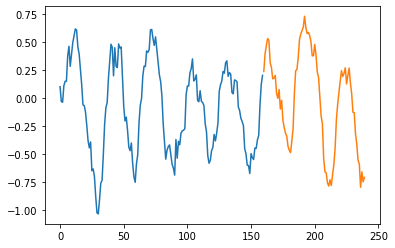

In [28]:
T = 240
gap = 160
s = 30
mu = 0
sigma = 0.1
phi = 0.9
def make_time_series():
    z0 = np.random.normal(0,sigma,1)
    z = np.zeros(T)
    z[0] = z0
    shocks = np.random.normal(mu, sigma, T)
    for idx_t in range(T-1):
        z[idx_t+1] = phi*z[idx_t] + shocks[idx_t+1] + 0.1*np.sin(2*np.pi*(idx_t)/s)
    return z
r = make_time_series()
r_train = r[:gap]
r_test = r[gap:]
plt.plot(range(gap),r_train)
plt.plot(range(gap,T),r_test)
plt.show()

def make_data():
    ts_ = np.linspace(0.1,24.,T)
    ts_ext_ = np.array([0.] + list(ts_) + [24.1])
    ts_vis_ = np.linspace(0., 24., 300)
    ys_ = r[:,None]
    ts = torch.tensor(ts_).float()
    ts_ext = torch.tensor(ts_ext_).float()
    ts_vis = torch.tensor(ts_vis_).float()
    ys = torch.tensor(ys_).float().to(device)
    return Data(ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_)  

In [8]:
'''
    theta = 0.5
    sigma = 1.0
    phi = 0.9
    AR_sigma = 0.1
    t = ts[:120]

    c = 0.15*torch.sin(2*np.pi*ts[:120]/3)
    AR_mean = torch.zeros(120)
    AR_std = torch.zeros(120)
    AR_mean[0] = c[0]/(1-phi)
    AR_std[0] = math.sqrt(AR_sigma**2/(1-phi**2))
    for i in range(1,120):
        AR_mean[i] = c[i] + phi*ys[i-1]
        AR_std[i] = AR_sigma
    AR_mean = AR_mean[:,None]
    AR_std = AR_std[:,None]
    AR_likelihood = {"laplace": distributions.Laplace, "normal": distributions.Normal}[args.likelihood]
    AR = AR_likelihood(loc=AR_mean, scale=AR_std)
    AR_logpy = AR.log_prob(ys[:120]).mean(dim=1)
    
    OU_likelihood= {"laplace": distributions.Laplace, "normal": distributions.Normal}[args.likelihood]
    '''

'\n    theta = 0.5\n    sigma = 1.0\n    phi = 0.9\n    AR_sigma = 0.1\n    t = ts[:120]\n\n    c = 0.15*torch.sin(2*np.pi*ts[:120]/3)\n    AR_mean = torch.zeros(120)\n    AR_std = torch.zeros(120)\n    AR_mean[0] = c[0]/(1-phi)\n    AR_std[0] = math.sqrt(AR_sigma**2/(1-phi**2))\n    for i in range(1,120):\n        AR_mean[i] = c[i] + phi*ys[i-1]\n        AR_std[i] = AR_sigma\n    AR_mean = AR_mean[:,None]\n    AR_std = AR_std[:,None]\n    AR_likelihood = {"laplace": distributions.Laplace, "normal": distributions.Normal}[args.likelihood]\n    AR = AR_likelihood(loc=AR_mean, scale=AR_std)\n    AR_logpy = AR.log_prob(ys[:120]).mean(dim=1)\n    \n    OU_likelihood= {"laplace": distributions.Laplace, "normal": distributions.Normal}[args.likelihood]\n    '

In [36]:
def main(loss_type="l2_only"):
    # Dataset.
    ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_ = make_data()

    theta = 0.5
    sigma = 1.0
    phi = 0.9
    AR_sigma = 0.1
    t = ts[:gap]

    c = 0.15*torch.sin(2*np.pi*ts[:gap]/3)
    AR_mean = torch.zeros(gap)
    AR_std = torch.zeros(gap)
    AR_mean[0] = c[0]/(1-phi)
    AR_std[0] = math.sqrt(AR_sigma**2/(1-phi**2))
    for i in range(1,gap):
        AR_mean[i] = c[i-1] + phi*ys[i-1]
        AR_std[i] = AR_sigma
    AR_mean = AR_mean[:,None]
    AR_std = AR_std[:,None]
    AR_likelihood = {"laplace": distributions.Laplace, "normal": distributions.Normal}[args.likelihood]
    AR = AR_likelihood(loc=AR_mean, scale=AR_std)
    cond_AR_logpy = AR.log_prob(ys[:gap])
    cond_AR_logpy = cond_AR_logpy.repeat(1,args.batch_size)
    #AR_logpy = torch.ones(cond_AR_logpy.shape[0])
    #AR_logpy[0] = cond_AR_logpy[0]
    #for i in range(1,AR_logpy.shape[0]):
        #AR_logpy[i] = AR_logpy[i-1]+cond_AR_logpy[i]
    # Plotting parameters.
    vis_batch_size = 1024
    ylims = (-1.75, 1.75)
    alphas = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55]
    percentiles = [0.999, 0.99, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    vis_idx = np.random.permutation(vis_batch_size)
    # From https://colorbrewer2.org/.
    if args.color == "blue":
        sample_colors = ('#8c96c6', '#8c6bb1', '#810f7c')
        fill_color = '#9ebcda'
        mean_color = '#4d004b'
        num_samples = len(sample_colors)
    else:
        sample_colors = ('#fc4e2a', '#e31a1c', '#bd0026')
        fill_color = '#fd8d3c'
        mean_color = '#800026'
        num_samples = len(sample_colors)

    eps = torch.randn(vis_batch_size, 1).to(device)  # Fix seed for the random draws used in the plots.
    bm = torchsde.BrownianInterval(
        t0=ts_vis[0],
        t1=ts_vis[-1],
        size=(vis_batch_size, 1),
        device=device,
        levy_area_approximation='space-time'
    )  # We need space-time Levy area to use the SRK solver

    # Model.
    model = LatentSDE().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=.999)
    kl_scheduler = LinearScheduler(iters=args.kl_anneal_iters)

    logpy_metric = EMAMetric()
    kl_metric = EMAMetric()
    loss_metric = EMAMetric()

    if args.show_prior:
        with torch.no_grad():
            zs = model.sample_p(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
            ts_vis_, zs_ = ts_vis.cpu().numpy(), zs.cpu().numpy()
            zs_ = np.sort(zs_, axis=1)

            img_dir = os.path.join(args.train_dir, 'prior.png')
            plt.subplot(frameon=False)
            for alpha, percentile in zip(alphas, percentiles):
                idx = int((1 - percentile) / 2. * vis_batch_size)
                zs_bot_ = zs_[:, idx]
                zs_top_ = zs_[:, -idx]
                plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

            # `zorder` determines who's on top; the larger the more at the top.
            plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
            plt.ylim(ylims)
            plt.xlabel('$t$')
            plt.ylabel('$Y_t$')
            plt.tight_layout()
            plt.savefig(img_dir, dpi=args.dpi)
            plt.show()
            plt.close()
            logging.info(f'Saved prior figure at: {img_dir}')

    for global_step in tqdm.tqdm(range(args.train_iters)):
        # Plot and save.
        if global_step % args.pause_iters == 0:
            img_path = os.path.join(args.train_dir, f'global_step_{global_step}.png')

            with torch.no_grad():
                zs = model.sample_q(ts=ts_vis, batch_size=vis_batch_size, eps=eps, bm=bm).squeeze()
                samples = zs[:, vis_idx]
                ts_vis_, zs_, samples_ = ts_vis.cpu().numpy(), zs.cpu().numpy(), samples.cpu().numpy()
                zs_ = np.sort(zs_, axis=1)
                plt.subplot(frameon=False)

                if args.show_percentiles:
                    for alpha, percentile in zip(alphas, percentiles):
                        idx = int((1 - percentile) / 2. * vis_batch_size)
                        zs_bot_, zs_top_ = zs_[:, idx], zs_[:, -idx]
                        plt.fill_between(ts_vis_, zs_bot_, zs_top_, alpha=alpha, color=fill_color)

                if args.show_mean:
                    plt.plot(ts_vis_, zs_.mean(axis=1), color=mean_color)

                if args.show_samples:
                    for j in range(num_samples):
                        plt.plot(ts_vis_, samples_[:, j], color=sample_colors[j], linewidth=1.0)

                if args.show_arrows:
                    num, dt = 12, 0.12
                    t, y = torch.meshgrid(
                        [torch.linspace(0.2, 1.8, num).to(device), torch.linspace(-1.5, 1.5, num).to(device)]
                    )
                    t, y = t.reshape(-1, 1), y.reshape(-1, 1)
                    fty = model.f(t=t, y=y).reshape(num, num)
                    dt = torch.zeros(num, num).fill_(dt).to(device)
                    dy = fty * dt
                    dt_, dy_, t_, y_ = dt.cpu().numpy(), dy.cpu().numpy(), t.cpu().numpy(), y.cpu().numpy()
                    plt.quiver(t_, y_, dt_, dy_, alpha=0.3, edgecolors='k', width=0.0035, scale=50)

                if args.hide_ticks:
                    plt.xticks([], [])
                    plt.yticks([], [])

                plt.scatter(ts_, ys_, marker='x', zorder=3, color='k', s=35)  # Data.
                plt.ylim(ylims)
                plt.xlabel('$t$')
                plt.ylabel('$Y_t$')
                plt.tight_layout()
                plt.savefig(img_path, dpi=args.dpi)
                plt.show()
                plt.close()
                logging.info(f'Saved figure at: {img_path}')

                if args.save_ckpt:
                    torch.save(
                        {'model': model.state_dict(),
                         'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(),
                         'kl_scheduler': kl_scheduler},
                        os.path.join(ckpt_dir, f'global_step_{global_step}.ckpt')
                    )

        # Train.
        optimizer.zero_grad()
        zs, kl = model(ts=ts_ext[:gap+2], batch_size=args.batch_size)
        zs = zs.squeeze()
        zs = zs[1:-1]  # Drop first and last which are only used to penalize out-of-data region and spread uncertainty.

        likelihood_constructor = {"laplace": distributions.Laplace, "normal": distributions.Normal}[args.likelihood]
        #likelihood = likelihood_constructor(loc=zs, scale=args.scale)
        #logpy = likelihood.log_prob(ys[:gap]).sum(dim=0).mean(dim=0)

        likelihood = likelihood_constructor(loc=zs, scale=args.scale)
        SDE_logpy = likelihood.log_prob(ys[:gap])
        
        if loss_type == "l2_only":
            logpy = torch.sqrt(((cond_AR_logpy - SDE_logpy)**2).sum(dim=0).mean(dim=0))
            loss = logpy 
        elif loss_type == "l2":
            logpy = torch.sqrt(((cond_AR_logpy - SDE_logpy)**2).sum(dim=0).mean(dim=0))
            loss = logpy + kl*kl_scheduler.val
        elif loss_type == "l1_only":
            logpy = (torch.abs(cond_AR_logpy-SDE_logpy)).sum(dim=0).mean(dim=0)
            loss = logpy
        elif loss_type == "l1":
            logpy = (torch.abs(cond_AR_logpy-SDE_logpy)).sum(dim=0).mean(dim=0)
            loss = logpy + kl*kl_scheduler.val
            
        
        #loss = -logpy + kl * kl_scheduler.val
        #+ kl*kl_scheduler.val
        
        loss.backward()

        optimizer.step()
        scheduler.step()
        kl_scheduler.step()

        logpy_metric.step(logpy)
        kl_metric.step(kl)
        loss_metric.step(loss)

        logging.info(
            f'global_step: {global_step}, '
            f'logpy: {logpy_metric.val:.3f}, '
            f'kl: {kl_metric.val:.3f}, '
            f'loss: {loss_metric.val:.3f}'
        )

In [43]:
parser = argparse.ArgumentParser()
parser.add_argument('--no-gpu', type=str2bool, default=False, const=True, nargs="?")
parser.add_argument('--debug', type=str2bool, default=False, const=True, nargs="?")
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--train-dir', type=str, required=True)
parser.add_argument('--save-ckpt', type=str2bool, default=False, const=True, nargs="?")

parser.add_argument('--data', type=str, default='segmented_cosine', choices=['segmented_cosine', 'irregular_sine'])
parser.add_argument('--kl-anneal-iters', type=int, default=100, help='Number of iterations for linear KL schedule.')
parser.add_argument('--train-iters', type=int, default=1000, help='Number of iterations for training.')
parser.add_argument('--pause-iters', type=int, default=50, help='Number of iterations before pausing.')
parser.add_argument('--batch-size', type=int, default=512, help='Batch size for training.')
parser.add_argument('--likelihood', type=str, choices=['normal', 'laplace'], default='normal')
#parser.add_argument('--scale', type=float, default=0.03, help='Scale parameter of Normal and Laplace.')
parser.add_argument('--scale', type=float, default=0.05, help='Scale parameter of Normal and Laplace.')

parser.add_argument('--adjoint', type=str2bool, default=False, const=True, nargs="?")
parser.add_argument('--adaptive', type=str2bool, default=False, const=True, nargs="?")
parser.add_argument('--method', type=str, default='milstein', choices=('euler', 'milstein', 'srk'),
                    help='Name of numerical solver.')
parser.add_argument('--dt', type=float, default=0.1)
parser.add_argument('--rtol', type=float, default=1e-5)
parser.add_argument('--atol', type=float, default=1e-5)
parser.add_argument('--show-prior', type=str2bool, default=True, const=True, nargs="?")
parser.add_argument('--show-samples', type=str2bool, default=False, const=True, nargs="?")
parser.add_argument('--show-percentiles', type=str2bool, default=True, const=True, nargs="?")
parser.add_argument('--show-arrows', type=str2bool, default=True, const=True, nargs="?")
parser.add_argument('--show-mean', type=str2bool, default=True, const=True, nargs="?")
parser.add_argument('--hide-ticks', type=str2bool, default=False, const=True, nargs="?")
parser.add_argument('--dpi', type=int, default=300)
parser.add_argument('--color', type=str, default='blue', choices=('blue', 'red'))
args = parser.parse_args(args=['--train-dir', './img/'])

# minimizing the loss between AR and SDE

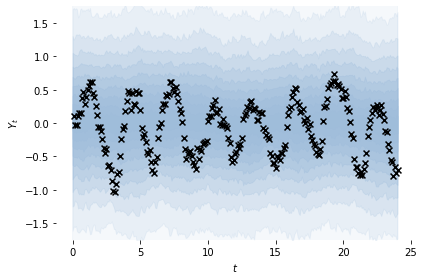

  0%|          | 0/1000 [00:00<?, ?it/s]

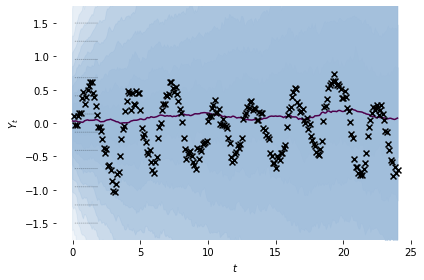

  5%|▌         | 50/1000 [00:27<08:07,  1.95it/s]

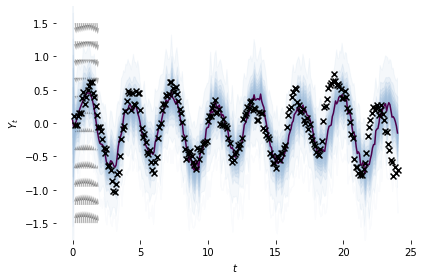

 10%|█         | 100/1000 [00:53<07:29,  2.00it/s]

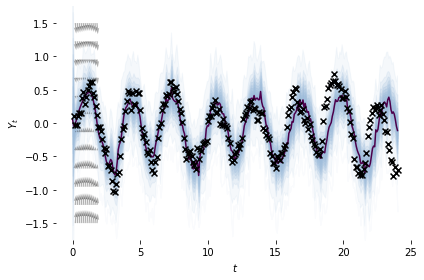

 15%|█▌        | 150/1000 [01:19<07:02,  2.01it/s]

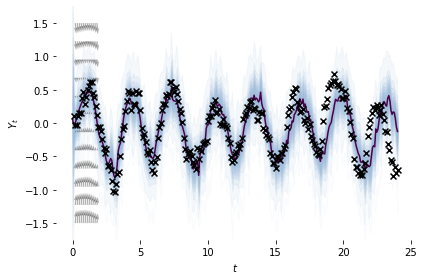

 20%|██        | 200/1000 [01:45<06:35,  2.02it/s]

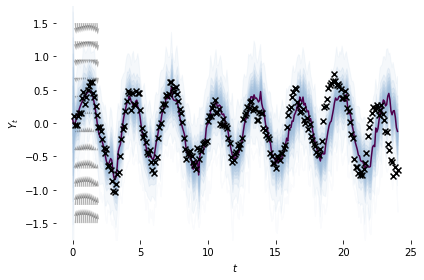

 25%|██▌       | 250/1000 [02:12<06:09,  2.03it/s]

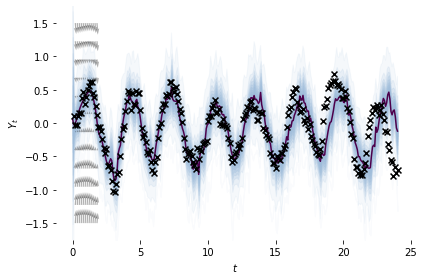

 30%|███       | 300/1000 [02:38<05:45,  2.03it/s]

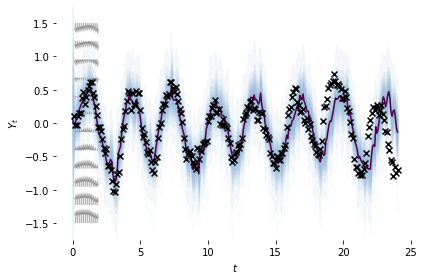

 35%|███▌      | 350/1000 [03:04<05:18,  2.04it/s]

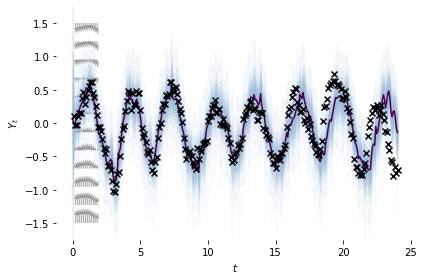

 40%|████      | 400/1000 [03:30<05:01,  1.99it/s]

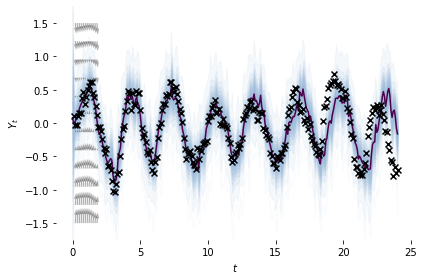

 45%|████▌     | 450/1000 [03:56<04:40,  1.96it/s]

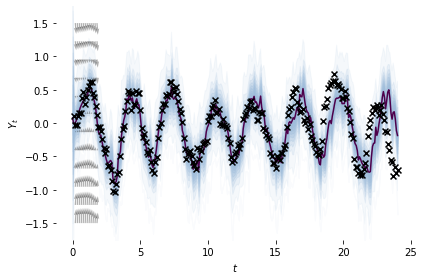

 50%|█████     | 500/1000 [04:22<04:07,  2.02it/s]

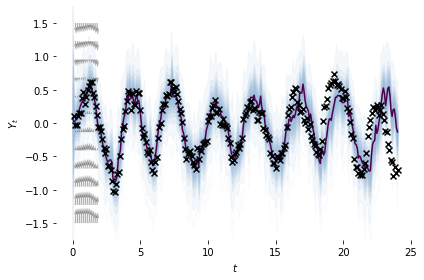

 55%|█████▌    | 550/1000 [04:49<03:42,  2.02it/s]

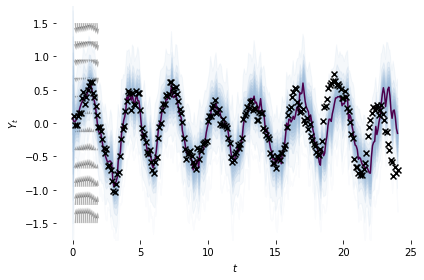

 60%|██████    | 600/1000 [05:15<03:19,  2.00it/s]

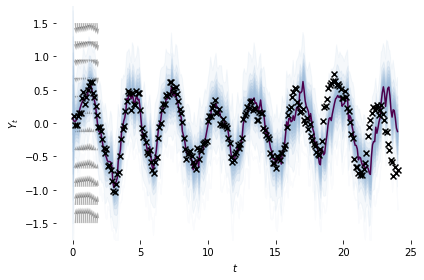

 65%|██████▌   | 650/1000 [05:41<02:54,  2.01it/s]

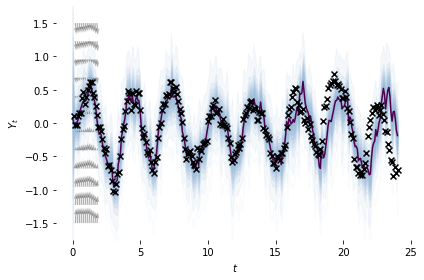

 70%|███████   | 700/1000 [06:07<02:28,  2.03it/s]

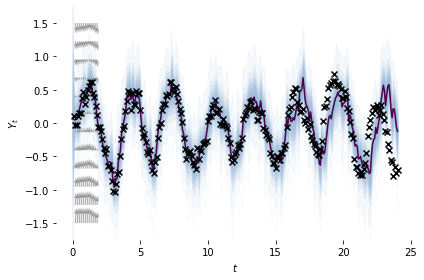

 75%|███████▌  | 750/1000 [06:34<02:05,  2.00it/s]

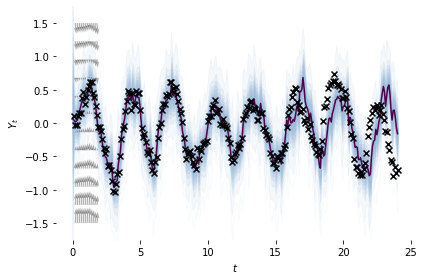

 80%|████████  | 800/1000 [07:00<01:39,  2.02it/s]

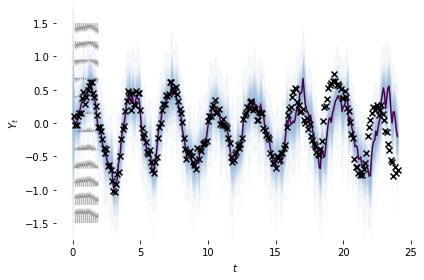

 85%|████████▌ | 850/1000 [07:26<01:14,  2.02it/s]

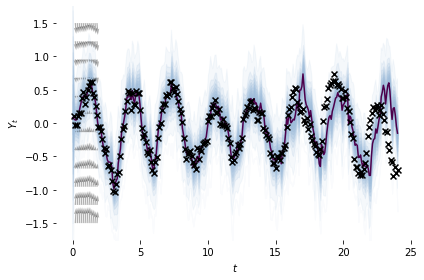

 90%|█████████ | 900/1000 [07:52<00:49,  2.02it/s]

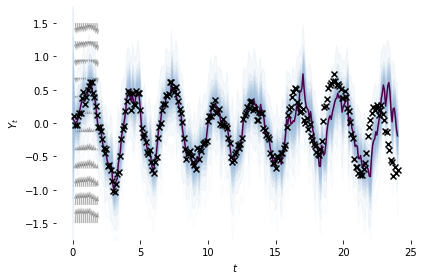

 95%|█████████▌| 950/1000 [08:18<00:24,  2.02it/s]

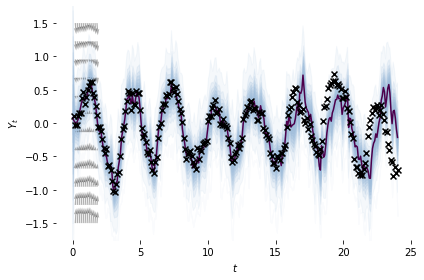

100%|██████████| 1000/1000 [08:44<00:00,  1.91it/s]


In [38]:
manual_seed(args.seed)

if args.debug:
    logging.getLogger().setLevel(logging.INFO)

ckpt_dir = os.path.join('./img/', 'ckpts')
os.makedirs(ckpt_dir, exist_ok=True)

sdeint_fn = torchsde.sdeint_adjoint if args.adjoint else torchsde.sdeint
torch.cuda.empty_cache()
# = LatentSDE().to(device)
main(loss_type="l2_only")

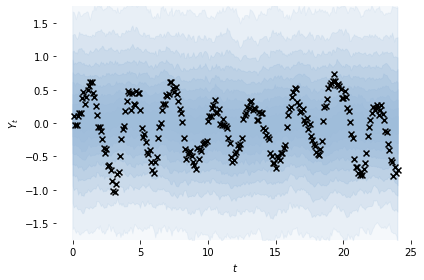

  0%|          | 0/1000 [00:00<?, ?it/s]

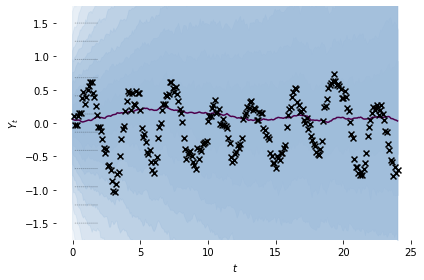

  5%|▌         | 50/1000 [00:26<07:53,  2.01it/s]

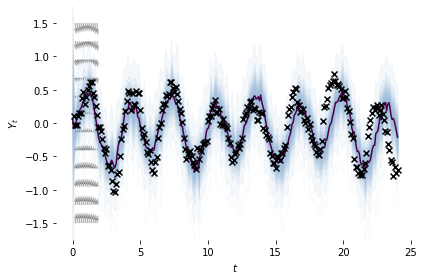

 10%|█         | 100/1000 [00:52<07:26,  2.01it/s]

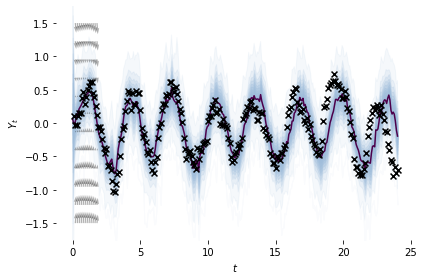

 15%|█▌        | 150/1000 [01:19<07:05,  2.00it/s]

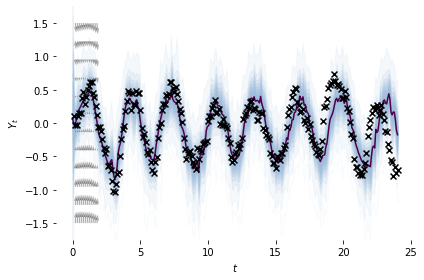

 20%|██        | 200/1000 [01:45<06:43,  1.98it/s]

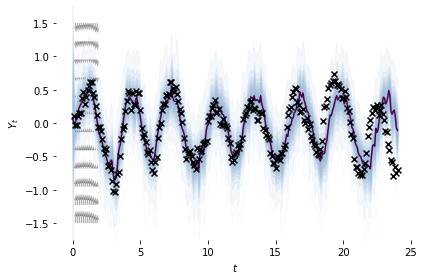

 25%|██▌       | 250/1000 [02:11<06:12,  2.02it/s]

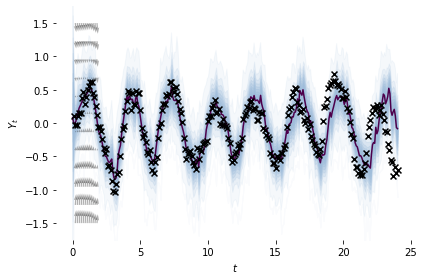

 30%|███       | 300/1000 [02:38<05:51,  1.99it/s]

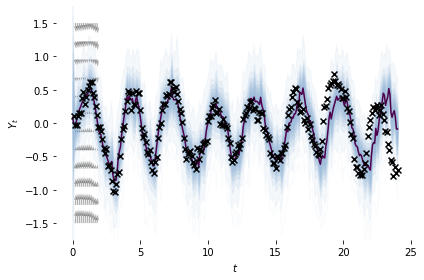

 35%|███▌      | 350/1000 [03:04<05:24,  2.00it/s]

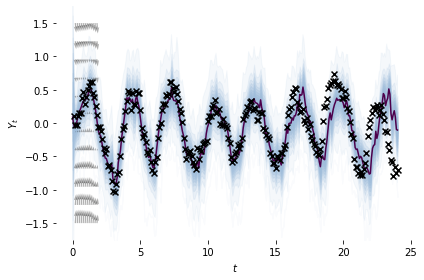

 40%|████      | 400/1000 [03:30<04:58,  2.01it/s]

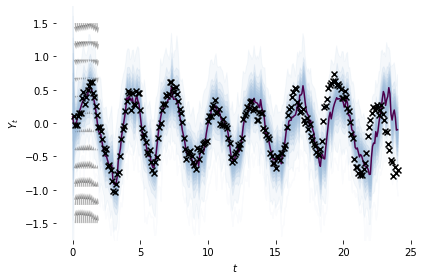

 45%|████▌     | 450/1000 [03:57<04:37,  1.98it/s]

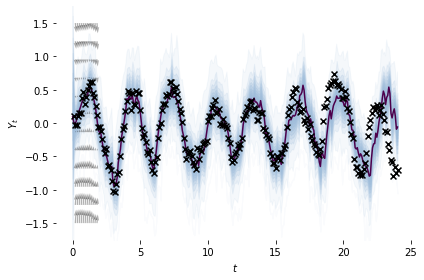

 50%|█████     | 500/1000 [04:23<04:09,  2.00it/s]

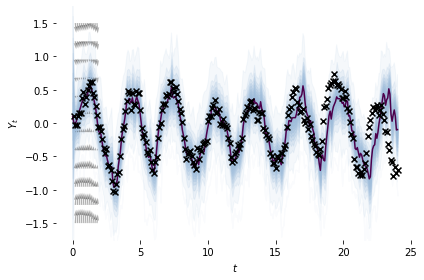

 55%|█████▌    | 550/1000 [04:49<03:46,  1.98it/s]

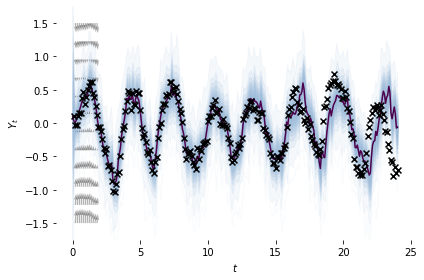

 60%|██████    | 600/1000 [05:16<03:23,  1.96it/s]

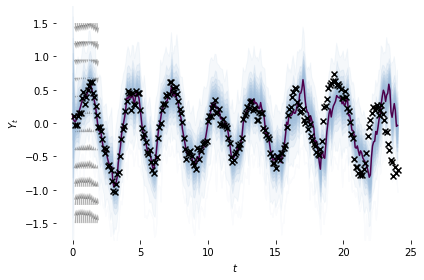

 65%|██████▌   | 650/1000 [05:42<02:55,  1.99it/s]

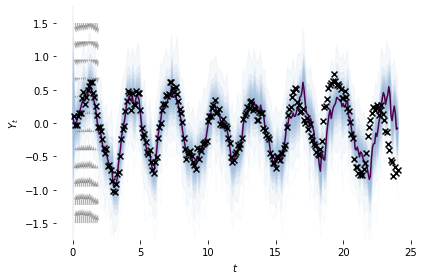

 70%|███████   | 700/1000 [06:09<02:29,  2.01it/s]

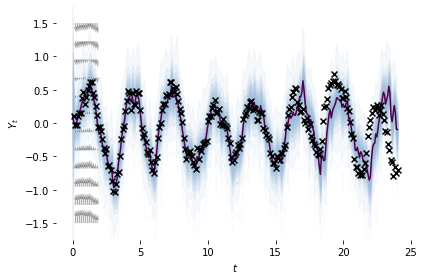

 75%|███████▌  | 750/1000 [06:35<02:04,  2.01it/s]

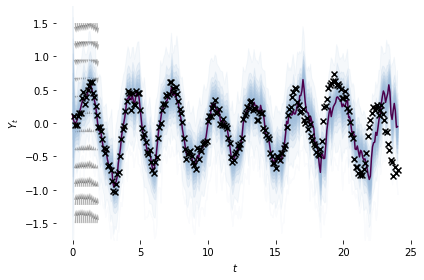

 80%|████████  | 800/1000 [07:01<01:40,  1.98it/s]

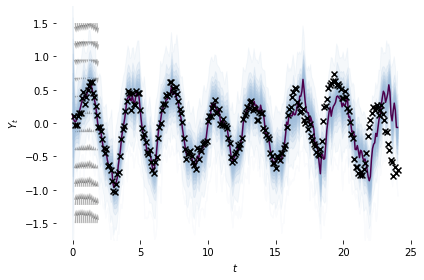

 85%|████████▌ | 850/1000 [07:28<01:14,  2.01it/s]

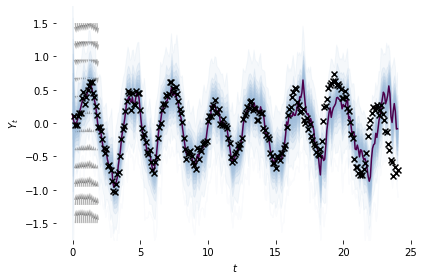

 90%|█████████ | 900/1000 [07:54<00:49,  2.01it/s]

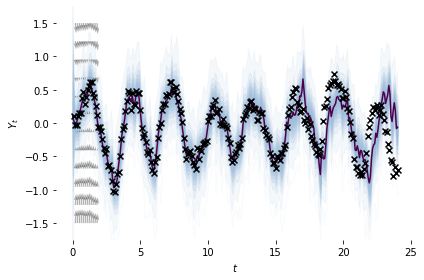

 95%|█████████▌| 950/1000 [08:21<00:24,  2.01it/s]

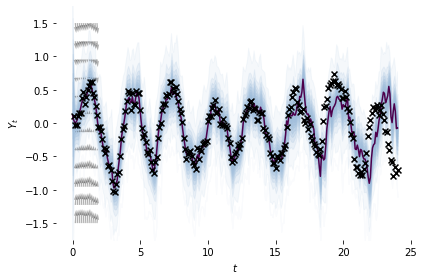

100%|██████████| 1000/1000 [08:47<00:00,  1.90it/s]


In [39]:
torch.cuda.empty_cache()
# = LatentSDE().to(device)
main(loss_type="l2")

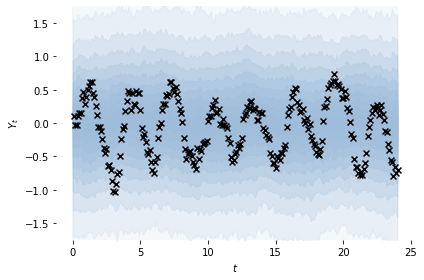

  0%|          | 0/1000 [00:00<?, ?it/s]

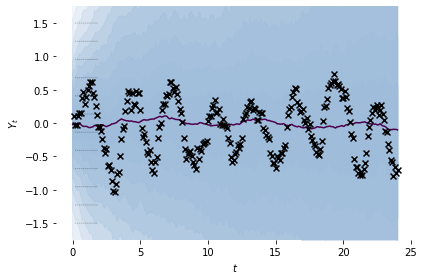

  5%|▌         | 50/1000 [00:26<08:21,  1.90it/s]

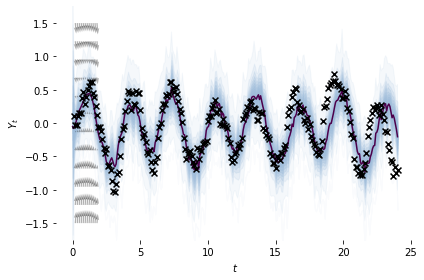

 10%|█         | 100/1000 [00:53<07:28,  2.01it/s]

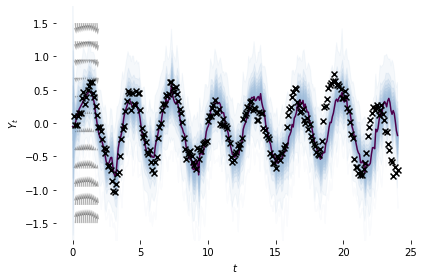

 15%|█▌        | 150/1000 [01:19<07:01,  2.02it/s]

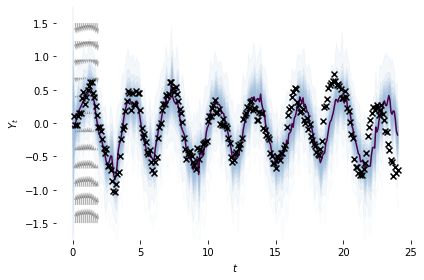

 20%|██        | 200/1000 [01:45<06:39,  2.00it/s]

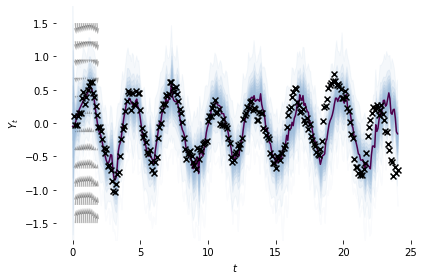

 25%|██▌       | 250/1000 [02:12<06:19,  1.97it/s]

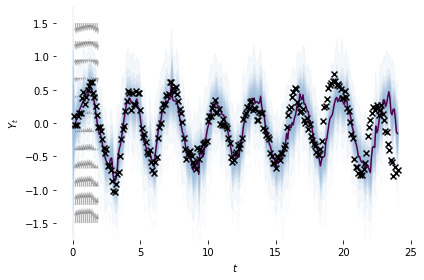

 30%|███       | 300/1000 [02:38<05:47,  2.02it/s]

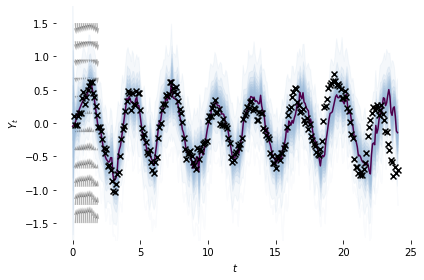

 35%|███▌      | 350/1000 [03:05<05:24,  2.00it/s]

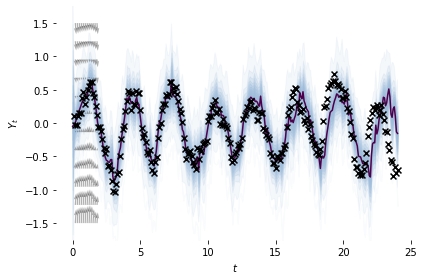

 40%|████      | 400/1000 [03:32<05:07,  1.95it/s]

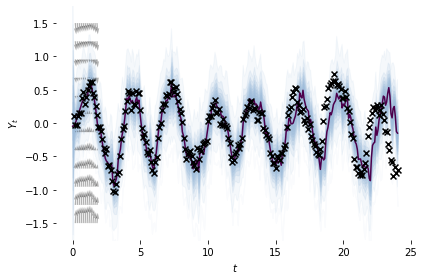

 45%|████▌     | 450/1000 [03:58<04:33,  2.01it/s]

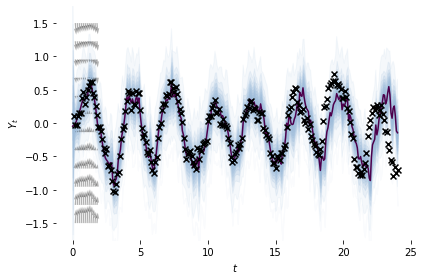

 50%|█████     | 500/1000 [04:24<04:17,  1.94it/s]

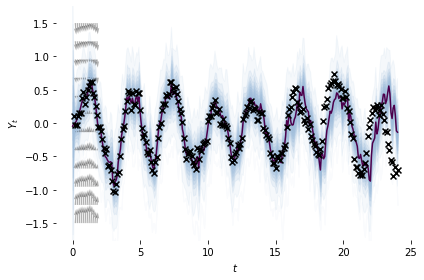

 55%|█████▌    | 550/1000 [04:51<03:43,  2.01it/s]

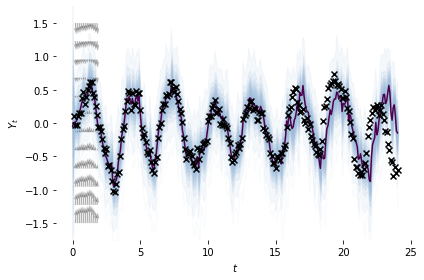

 60%|██████    | 600/1000 [05:17<03:18,  2.02it/s]

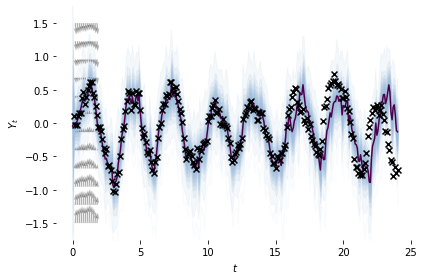

 65%|██████▌   | 650/1000 [05:43<02:53,  2.02it/s]

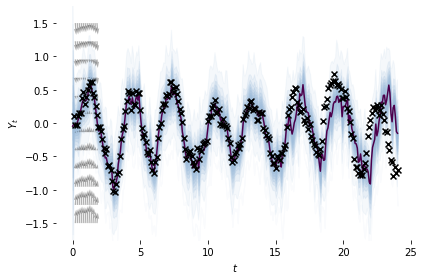

 70%|███████   | 700/1000 [06:09<02:28,  2.02it/s]

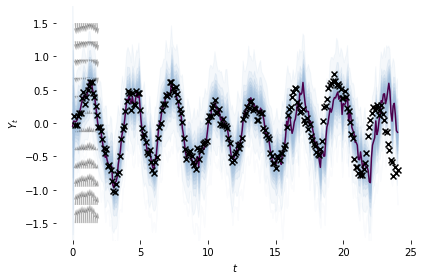

 75%|███████▌  | 750/1000 [06:36<02:12,  1.88it/s]

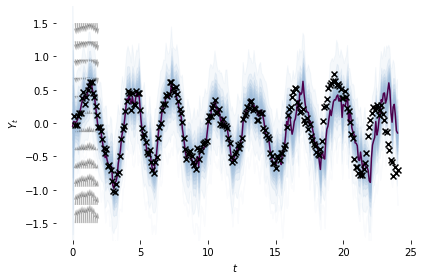

 80%|████████  | 800/1000 [07:03<01:42,  1.95it/s]

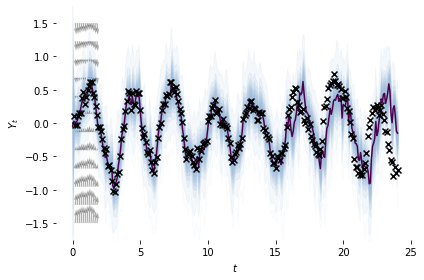

 85%|████████▌ | 850/1000 [07:30<01:14,  2.00it/s]

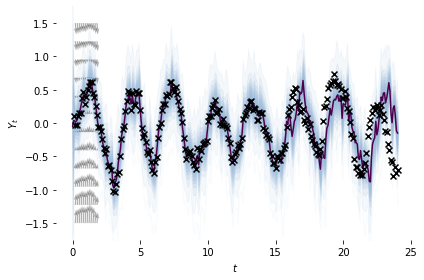

 90%|█████████ | 900/1000 [07:57<00:50,  1.99it/s]

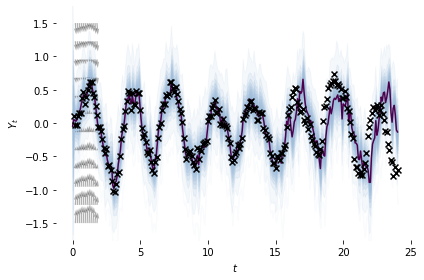

 95%|█████████▌| 950/1000 [08:23<00:25,  1.95it/s]

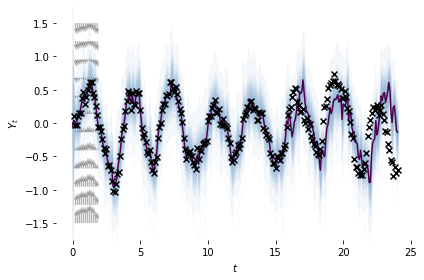

100%|██████████| 1000/1000 [08:49<00:00,  1.89it/s]


In [40]:
torch.cuda.empty_cache()
# = LatentSDE().to(device)
main(loss_type="l1_only")

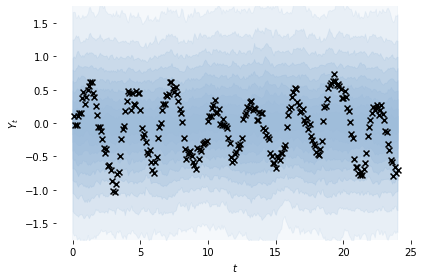

  0%|          | 0/1000 [00:00<?, ?it/s]

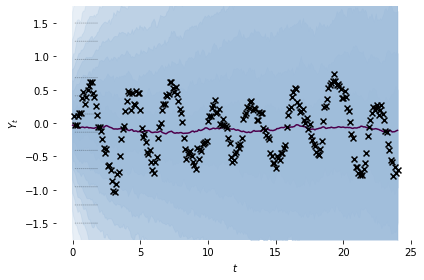

  5%|▌         | 50/1000 [00:26<07:51,  2.01it/s]

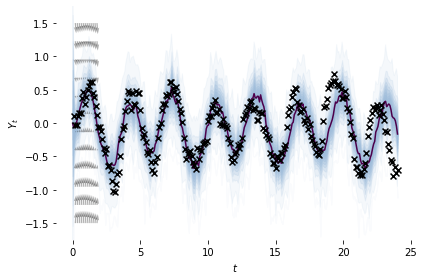

 10%|█         | 100/1000 [00:52<07:27,  2.01it/s]

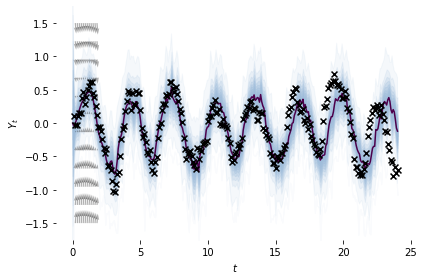

 15%|█▌        | 150/1000 [01:19<07:07,  1.99it/s]

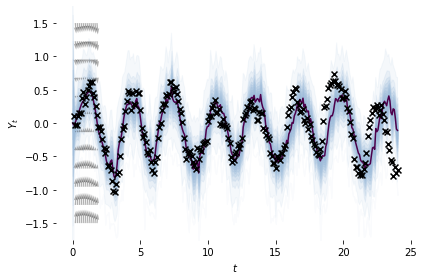

 20%|██        | 200/1000 [01:46<06:36,  2.02it/s]

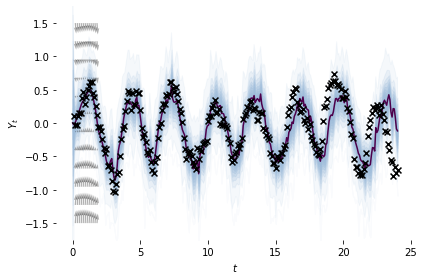

 25%|██▌       | 250/1000 [02:13<06:18,  1.98it/s]

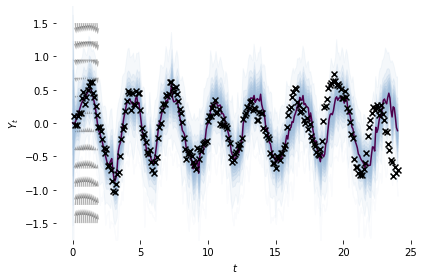

 30%|███       | 300/1000 [02:39<05:53,  1.98it/s]

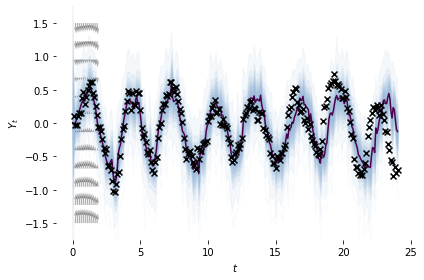

 35%|███▌      | 350/1000 [03:06<05:32,  1.96it/s]

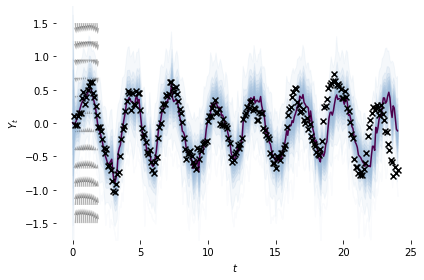

 40%|████      | 400/1000 [03:32<05:08,  1.94it/s]

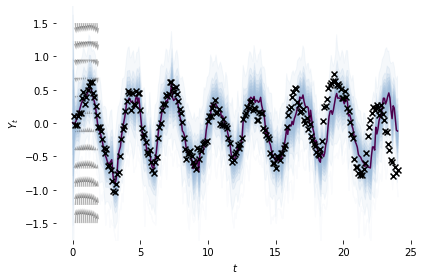

 45%|████▌     | 450/1000 [03:58<04:35,  2.00it/s]

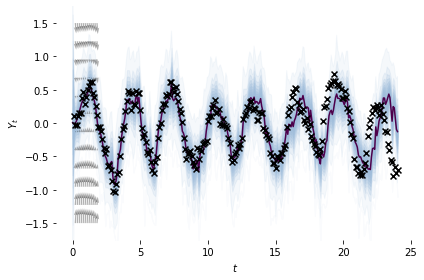

 50%|█████     | 500/1000 [04:25<04:15,  1.95it/s]

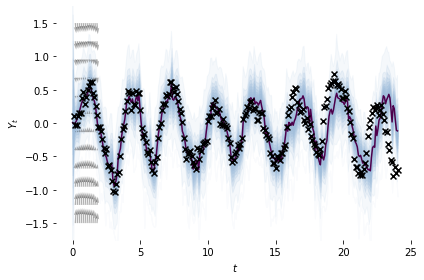

 55%|█████▌    | 550/1000 [04:52<03:43,  2.01it/s]

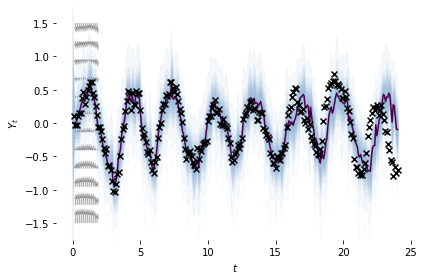

 60%|██████    | 600/1000 [05:18<03:19,  2.00it/s]

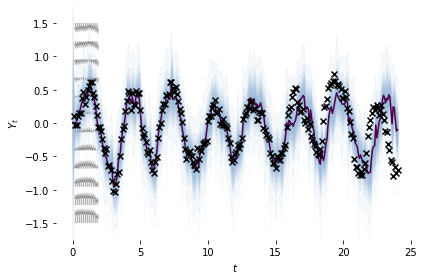

 65%|██████▌   | 650/1000 [05:45<02:57,  1.98it/s]

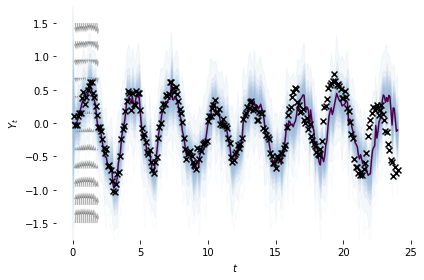

 70%|███████   | 700/1000 [06:11<02:29,  2.00it/s]

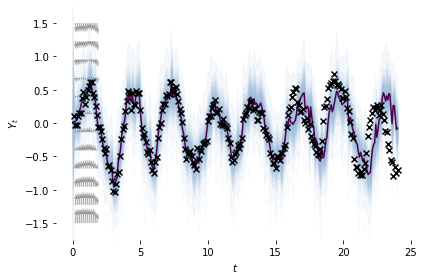

 75%|███████▌  | 750/1000 [06:37<02:04,  2.00it/s]

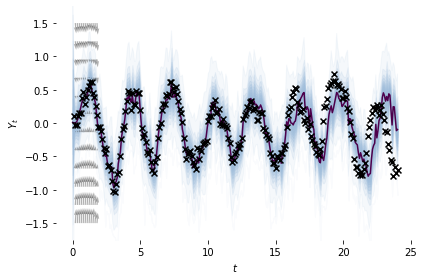

 80%|████████  | 800/1000 [07:04<01:40,  1.98it/s]

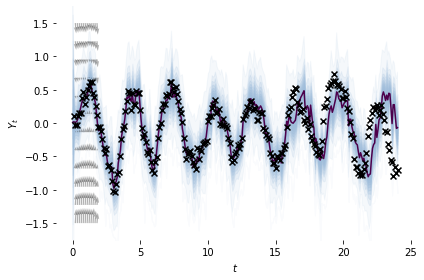

 85%|████████▌ | 850/1000 [07:30<01:15,  1.99it/s]

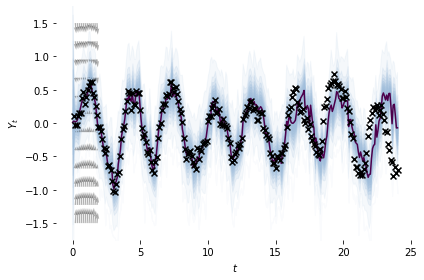

 90%|█████████ | 900/1000 [07:57<00:50,  1.96it/s]

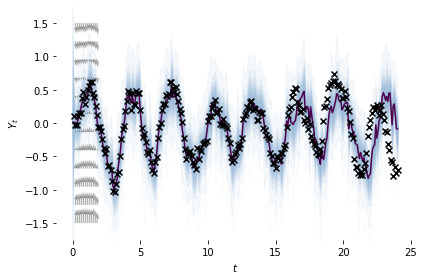

 95%|█████████▌| 950/1000 [08:24<00:24,  2.00it/s]

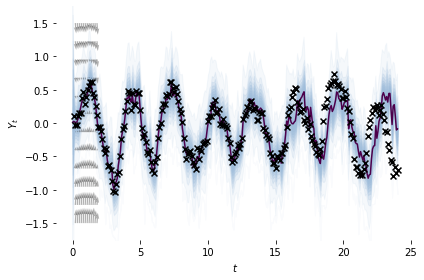

100%|██████████| 1000/1000 [08:51<00:00,  1.88it/s]


In [41]:
torch.cuda.empty_cache()
# = LatentSDE().to(device)
main(loss_type="l1")

# testing function to make sure that the condition log likelihood and log probability of SDE.

## log likelihood of AR(1)

In [73]:
ts_, ts_ext_, ts_vis_, ts, ts_ext, ts_vis, ys, ys_ = make_data()

In [74]:
torch.pi = torch.acos(torch.zeros(1)).item() * 2
def log_likelihood(p,r):
    T = r.shape[0]
    t = np.linspace(1,T,T)
    c = 0.1*np.sin(2*np.pi*t/s)
    epsilon = np.zeros(T)
    for i in range(1,T):
        epsilon[i] = r[i] - phi*r[i-1] - c[i]
    ll = -0.5 * (T - p) * np.log(2 * np.pi) - 0.5 * (T - p) * np.log(sigma ** 2) - 0.5 * np.dot(epsilon, epsilon) * sigma ** (-2)
    return ll
log_likelihood(1,ys)

180.48394202849408

In [77]:
import statsmodels.api as sm
import scipy.stats as scistats

model = sm.tsa.AutoReg(endog=r,lags=1, trend="c")
result = model.fit()
llf = result.llf
print(llf)

127.19230676776665


In [119]:
theta = 0.5
sigma = 1.0
t = ts[:120]
mean = torch.zeros(t.shape[0])[:,None]
std = (sigma**2/2/theta)*(1-torch.exp(-2*theta*t))[:,None]
likelihood_constructor = {"laplace": distributions.Laplace, "normal": distributions.Normal}[args.likelihood]
likelihood = likelihood_constructor(loc=mean, scale=std)
logpy = likelihood.log_prob(ys[:120])#.mean(dim=0)
print(logpy)

tensor([[ 1.0071],
        [ 0.2977],
        [ 0.4706],
        [-0.3011],
        [-0.5224],
        [-0.8659],
        [-1.0209],
        [-1.2786],
        [-1.5038],
        [-1.5244],
        [-1.5112],
        [-1.4186],
        [-1.3961],
        [-1.3500],
        [-1.3278],
        [-1.1633],
        [-1.1024],
        [-1.0044],
        [-0.9049],
        [-0.9187],
        [-0.7624],
        [-0.5973],
        [-0.7407],
        [-0.7394],
        [-0.8491],
        [-0.8704],
        [-1.1642],
        [-1.3587],
        [-1.4984],
        [-1.3525],
        [-1.4564],
        [-1.2984],
        [-1.1808],
        [-1.0343],
        [-0.7789],
        [-0.7747],
        [-1.1179],
        [-1.1422],
        [-1.4318],
        [-1.4729],
        [-1.4994],
        [-1.5781],
        [-1.4908],
        [-1.5244],
        [-1.4716],
        [-1.4698],
        [-1.4878],
        [-1.5231],
        [-1.3127],
        [-1.1242],
        [-1.0709],
        [-1.0231],
        [-0.

In [ ]:
torch.pi = torch.acos(torch.zeros(1)).item() * 2
def log_likelihood_batch(p,rm):
    T = rm.shape[1]
    t = torch.linspace(1,T,T)
    c = 0.1*torch.sin(2*torch.pi*t/s)
    lls = torch.zeros(rm.shape[0])
    for i in range(len(rm)):
        r = rm[i]
        epsilon = torch.zeros(T)
        for i in range(1,T):
            epsilon[i] = r[i] - phi*r[i-1] - c[i]
        sigma = torch.std(epsilon)
        ll = -0.5 * (T - p) * math.log(2 * torch.pi) - 0.5 * (T - p) * math.log(sigma ** 2) 
        ll = ll - 0.5 * torch.dot(epsilon, epsilon) * sigma ** (-2)
        lls[i] = ll
    return lls

In [128]:
llg = log_likelihood(1,ys[:gap])
llg

-110.148487044432

# adding the O-U process log probability to the loss function